## Histogram of Oriented Gradients (HOG)

In this post, we will dive into Histogram of Oriented Gradients (HOG), which is commonly used extract features of images... And implement it in python (in order to comprehend it).

### Feature Descriptor

A _feature descriptor_ is a representation of an image (or image patch) simplifying the iamge by extracting useful information and throwing away irrelevant information.

A _feature descriptor_ converts an image of size $W \times H \times 3$ to a feature vector of length $N$

#### What is considered _useful_?
It depends on purpose. For ex, it might not be good for image viewing, but for classification since using it produces good results.

In the HOG feature descriptor, the distribution (histograms) of directions of gradients (oriented gradients) are used as features. Gradients of an image are useful because the mangitude of gradients is large around edges and corners which contain a lot more information about object shape than flat regions.

### How to calculate HOG?

P/s: To make sure the calculation is correctly, we will compare the result of our manual implementation with that of `skimage`.

#### Step1: Preprocessing images
- Crop image (if needed). Here, I use an image of size 512 x 512 (from skimage)
- Convert to grayscale

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color

original_image = data.astronaut()
image = color.rgb2gray(data.astronaut())

print("original: %s --> grayscale: %s" % (original_image.shape, image.shape))

original: (512, 512, 3) --> grayscale: (512, 512)


#### Step 2: Compute gradient images
- The gradients involve gradients by x axis (indicating horizontal change) and gradients by y axis (vertical change)
- $g_x, g_y \in \mathbf{R}^{H \times W}$

Note that we calculate the gradient using the approximation for discrete value: 
$f'(x) \approx \frac{f(x+h) - f(x)}{h}$.

In the case of image, we chose $h = 1$, corresponding to 1 pixel.

In fact, the approximation is called _forward difference_. We also have other candidates to approximate the gradient as follows:
- Backward difference: $f'(x) = f(x) - f(x-1)$
- Forward difference: $f'(x) = f(x+1) - f(x)$ (like above)
- Central difference: $f'(x) = \frac{f(x+1) - f(x-1)}{2}$

In this post, I will use three of them: backward/forward difference for the edge pixels, central difference for rest. Some approaches do not care about the 4 edges and set them to zero. 

However, I use the three approximations above because it is consistent with the implementation of `np.gradient()` which is a _standardly correct function_ I can use to check my own code. Another reason is that `skimage.feature.hog` is implemented in the same way. I will be able to compare my result with that computed by `skimage`.

In [2]:
def compute_gradient(image: np.ndarray):
    """
    Compute gradient of an image by rows and columns
    """
    gx = np.zeros_like(image)
    gy = np.zeros_like(image)  # Central difference
    gx[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2
    gy[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2

    # Forward difference
    gx[:, 0] = image[:, 1] - image[:, 0]
    gy[0, :] = image[1, :] - image[0, :]
    
    # Backward difference
    gx[:, -1] = image[:, -1] - image[:, -2]
    gy[-1, :] = image[-1, :] - image[-2, :]
    
    return gx, gy

gx, gy = compute_gradient(image)

# Check with np.gradient()
gy_check, gx_check = np.gradient(image) # Note that the result of np.gradient is in the reversed order

print('diff_gx:', np.linalg.norm(gx - gx_check))
print('diff_gy', np.linalg.norm(gy - gy_check))

diff_gx: 0.0
diff_gy 0.0


Now let's see what information $g_x$ and $g_y$ carry.

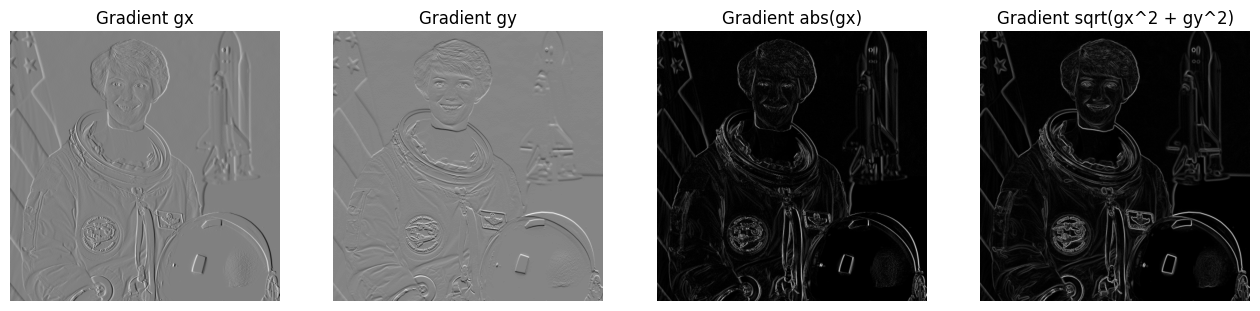

In [3]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off') 

ax1.imshow(gx, cmap=plt.get_cmap('gray'))
ax1.set_title('Gradient gx')

ax2.imshow(gy, cmap=plt.get_cmap('gray'))
ax2.set_title('Gradient gy')

ax3.imshow(np.abs(gx), cmap=plt.get_cmap('gray'))
ax3.set_title('Gradient abs(gx)')

ax4.imshow(np.hypot(gx, gy), cmap=plt.get_cmap('gray')) # np.hypo(gx, gy) = np.sqrt(gx**2 + gy**2)
ax4.set_title('Gradient sqrt(gx^2 + gy^2)')
plt.show()

Basically, $gx$ and $gy$ represent the edges of objects pretty well. We could intuitively think that changes in pixel values occur almost and significantly at object edges.

We could understand the gradients as a set of vectors $\vec{d} = \vec{dx} + \vec{dy}$, each of which is associated with a pixel $(x, y)$.

<u>Note</u>: 
- The visualizations of $gx$ and $gy$ are almost gray because they have negative values which turn the regions with zero gradient to neutral gray. The unsigned gradient (ie. $\lvert g_x \lvert, \lvert g_y \lvert$) of them should produce the very similar results as the rightmost image.

#### Step 3: Compute HOG in each cell
The edges above somehow resemble the sketch of the object, but quite smoother. In practice, _rough sketch_ is good enough to classify objects. Therefore, we will only care just a few orientations of $\vec{d}$ and in local regions (rather than every pixel).

We divide the image into many cells of size (8x8). These cells are also usually called _**patches**_. In this example, the size of the image is (512x512), so we have (64x64) patches in total. Oh, don't forget to divide the total magnitudes in each bin by the number of pixels per patch.

For each patch, we extract a vector of 9 bins (corresponding to angles $20^\circ, 40^\circ, ..., 160^\circ$). A pixel that has orientation $95^\circ$, magnitude $1.5$ should add up an amount of $1.5$ to the bin $80^\circ$.

This vector gives information about the statistic of the how popular each considered orientation is _(ie. the distribution of orientations)_. For example, a vector _v = (**12**, 0, 0.1, 0.7, 0.2, 0, 0, 0, 0.1)_ indicates the frequent appearance of horizontal strokes.

In [4]:
def compute_hog_cell(n_orientations: int, magnitudes: np.ndarray, orientations: np.ndarray) -> np.ndarray:
    """
    Compute 1 HOG feature of a cell. Return a row vector of size `n_orientations`
    """
    bin_width = int(180 / n_orientations)
    hog = np.zeros(n_orientations)
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            orientation = orientations[i, j]
            lower_bin_idx = int(orientation / bin_width)
            hog[lower_bin_idx] += magnitudes[i, j]
    
    return hog / (magnitudes.shape[0] * magnitudes.shape[1])

#### Step 4: Block normalization

Up to this step, we have created a histogram based on the gradients of the image. However, the gradients are sensitive to illumination. For example, if we darken the image by a half of light, the gradient magnitudes will decrease twice which means the histogram values change by half. A practical way to alleviate this dependence is normalizing the histogram.

We could perform normalization in larger regions. This stage is called _**block normalization**_. For example, we could take a block of 4 (square aligned) cells to normalize and take the result as a final histogram feature. We slide to the right and then down to get histogram features for other blocks. 

Note: 
- These blocks could overlap each other.
- Each histogram of a block is a row vector of size 36 (4 cells/block)

In this examples, with 4 cells/block, there are 63x63 blocks. So, we 63x63 histogram vectors of size 36.

--> 63*63*36 = **142884** numbers

In [5]:
def normalize_vector(v, eps=1e-5):
    """
    Return a normalized vector (which has norm2 as 1) 
    """
    # eps is used to prevent zero divide exceptions (in case v is zero)
    return v / np.sqrt(np.sum(v ** 2) + eps ** 2) 
    

def compute_hog_features(image: np.ndarray,
                         n_orientations: int = 9, pixels_per_cell: (int, int) = (8, 8),
                         cells_per_block: (int, int) = (1, 1)) -> np.ndarray:
    """
    Compute HOG features of an image. Return a row vector
    """
    gx, gy = compute_gradient(image)
    sy, sx = gx.shape
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    
    magnitudes = np.hypot(gx, gy)   # = np.sqrt(gx**2 + gy**2)
    orientations = np.rad2deg(np.arctan2(gy, gx)) % 180
    
    n_cellsx = int(sx / cx) # Number of cells in x axis
    n_cellsy = int(sy / cy) # Number of cells in y axis
    n_blocksx = int(n_cellsx - bx) + 1
    n_blocksy = int(n_cellsy - by) + 1
    
    hog_cells = np.zeros((n_cellsx, n_cellsy, n_orientations))
    
    prev_x = 0
    # Compute HOG of each cell
    for it_x in range(n_cellsx):
        prev_y = 0
        for it_y in range(n_cellsy):
            magnitudes_patch = magnitudes[prev_y:prev_y + cy, prev_x:prev_x + cx]
            orientations_patch = orientations[prev_y:prev_y + cy, prev_x:prev_x + cx]
            
            hog_cells[it_y, it_x] = compute_hog_cell(n_orientations, magnitudes_patch, orientations_patch)
            
            prev_y += cy
        prev_x += cx
    
    hog_blocks_normalized = np.zeros((n_blocksx, n_blocksy, n_orientations))
    
    # Normalize HOG by block
    for it_blocksx in range(n_blocksx):
        for it_blocky in range(n_blocksy):
            hog_block = hog_cells[it_blocky:it_blocky + by, it_blocksx:it_blocksx + bx].ravel()
            hog_blocks_normalized[it_blocky, it_blocksx] = normalize_vector(hog_block)
    
    return hog_blocks_normalized.ravel()

In [6]:
# Compare the results with skimage.feature.hog
hog_features = compute_hog_features(
    image, n_orientations=9, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(1, 1))

from skimage.feature import hog

hog_features_check = hog(
    image, orientations=9,
    pixels_per_cell=(8, 8), cells_per_block=(1, 1),
    block_norm='L2')

assert hog_features.shape == hog_features_check.shape
print(hog_features)
print(np.allclose(hog_features, hog_features_check))
print(hog_features.shape)

[0.25521159 0.1914571  0.         ... 0.296857   0.34306723 0.10241611]
False
(36864,)


Now, visualize the HOG features. Actually, I do not implement it since it is a bit cumbersome to reconstruct the image from these histogram info. Instead, I use the available function `skimage.feature.hog` to plot the HOG image so that we could have a sense of its benefits.

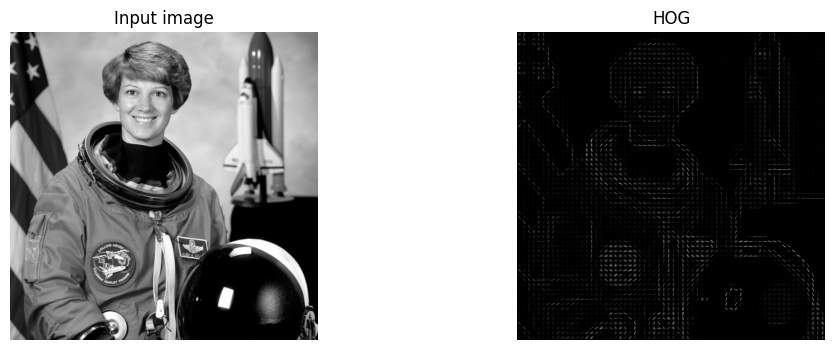

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

_, hog_image = hog(
    image, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(1, 1), block_norm='L2',
    visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.axis('off'); ax2.axis('off')
ax1.imshow(image, cmap=plt.get_cmap('gray'))
ax1.set_title('Input image')

ax2.imshow(hog_image, cmap=plt.get_cmap('gray'))
ax2.set_title('HOG')
plt.show()

### Reference
[1] http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf

[2] http://www.learnopencv.com/histogram-of-oriented-gradients/

[3] http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/